In [2]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [3]:
import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters

# Define

In [4]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

def draw_xvline(segments):
    for seg in segments:
        x0 = seg[0]
        plt.axvline(x=x0)
        
def draw_approximate_line(ax_set):
    fig, axs = plt.subplots(1,1, figsize=(25, 5))
    x0,y0,x1,y1 = ax_set[0]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for ax in ax_set:
        axs.plot((x1,ax[0]),(y1,ax[1]),ls='--',color='black',alpha=0.5)
        x0,y0,x1,y1 = ax
        axs.plot((x0,x1),(y0,y1),alpha=1,color=random.choice(colors))
    plt.show();

## Những segment có F1 > 0.5 thì coi như detect được

In [5]:
def get_anomaly_segment(line_segments):
    distance = [line_segments[0][3] - line_segments[1][1]]
    for i in range(1,len(line_segments)-1):
        left_distance = line_segments[i][1] - line_segments[i-1][3]
        right_distance = line_segments[i][3] - line_segments[i+1][1]
        dis = abs(left_distance + right_distance)
        distance.append(dis)
    last_dis = line_segments[len(line_segments)-1][1] - line_segments[len(line_segments)-2][3]
    distance.append(last_dis)
    return line_segments[distance.index(max(distance))]
def metrics(data,anomaly_idx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    anomaly = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    anomaly[anomaly_idx] = 1
    pred[predict_index] = 1
    
    tp = sum((a == 1 and p == 1) for a, p in zip(anomaly, pred))
    fp = sum((a == 0 and p == 1) for a, p in zip(anomaly, pred))
    fn = sum((a == 1 and p == 0) for a, p in zip(anomaly, pred))
    tn = sum((a == 0 and p == 0) for a, p in zip(anomaly, pred))
    
    accuracy = (tp + tn) / len(anomaly)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    result ={'Metrics':['Accuracy' ,'Precision','Recall','F1-score' ],
             'Score':[accuracy,precision, recall, f1]}
    result = pd.DataFrame(result)
    display(result)
    return accuracy,precision,recall,f1

# Data

In [6]:
num_datapoints = 8640
time_index = pd.date_range(start='2024-01-01', periods=num_datapoints, freq='s')

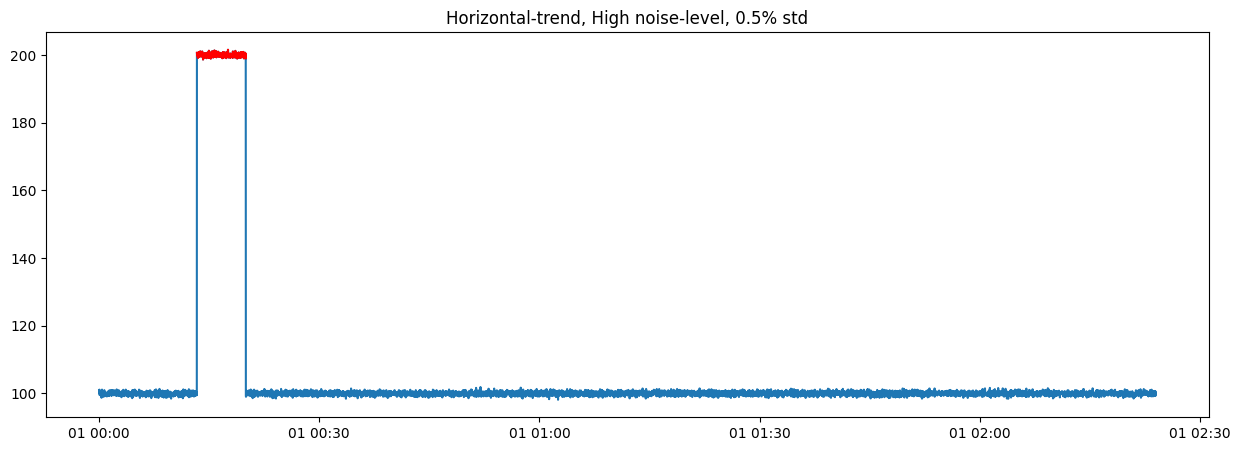

In [7]:
mean_traffic = 100  
std_dev_traffic = 0.5

start_noise_period = 800 
end_noise_period = 1200
noise_level = 100 
noise = np.zeros(num_datapoints)
noise[start_noise_period:end_noise_period] = np.full(400,noise_level)

traffic_data = np.random.normal(loc=mean_traffic, scale=std_dev_traffic, size=num_datapoints)
traffic_data_with_noise = traffic_data + noise


network_traffic_df = pd.DataFrame( {'Traffic_Mbps': traffic_data_with_noise},index=time_index)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(network_traffic_df)
ax.plot(network_traffic_df[start_noise_period:end_noise_period],c='r')
ax.set_title('Horizontal-trend, High noise-level, 0.5% std');

In [8]:
anomaly_idx = list(np.arange(start_noise_period,end_noise_period))

# Feature

In [66]:
ts = pd.DataFrame(network_traffic_df['Traffic_Mbps'])
ts['id'] = 1

In [67]:
extracted_feature = tsfresh.extract_features(ts,column_id='id',column_value='Traffic_Mbps')

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [01:05<00:00, 65.64s/it]


In [69]:
extracted_relevant_feature = pd.DataFrame(extracted_feature,columns=['Traffic_Mbps__mean',
                                                                     'Traffic_Mbps__median',
                                                                     'Traffic_Mbps__variance',
                                                                     'Traffic_Mbps__standard_deviation',
                                                                     'Traffic_Mbps__absolute_sum_of_changes',
                                                                     'Traffic_Mbps__mean_abs_change',
                                                                     'Traffic_Mbps__kurtosis',
                                                                     'Traffic_Mbps__minimum',
                                                                     'Traffic_Mbps__maximum']).T
extracted_relevant_feature = extracted_relevant_feature.rename(columns={1: 'Traffic_Mbps'})
extracted_relevant_feature.index = ['mean','median','variance','standard_deviation','absolute_sum_of_changes','mean_abs_change',
                                      'kurtosis','minimum','maximum']

In [70]:
extracted_relevant_feature

,Traffic_Mbps
mean,104.621483
median,100.014344
variance,442.227086
standard_deviation,21.029196
absolute_sum_of_changes,4986.149682
mean_abs_change,0.577167
kurtosis,16.640276
minimum,98.129950
maximum,201.585487


# Top-down

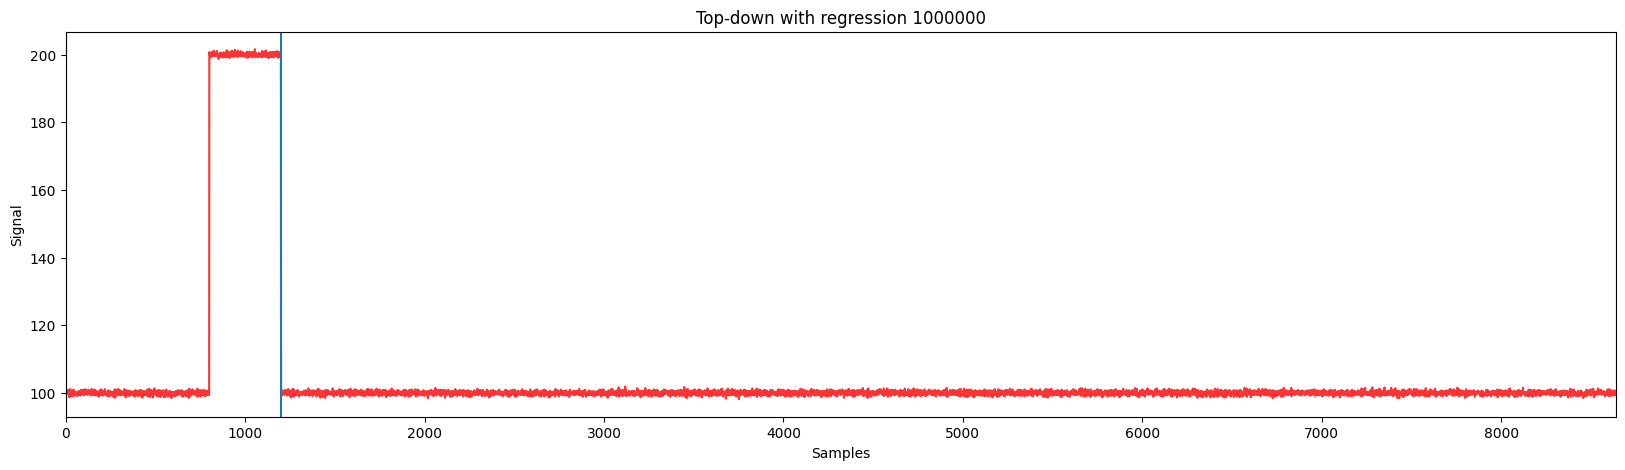

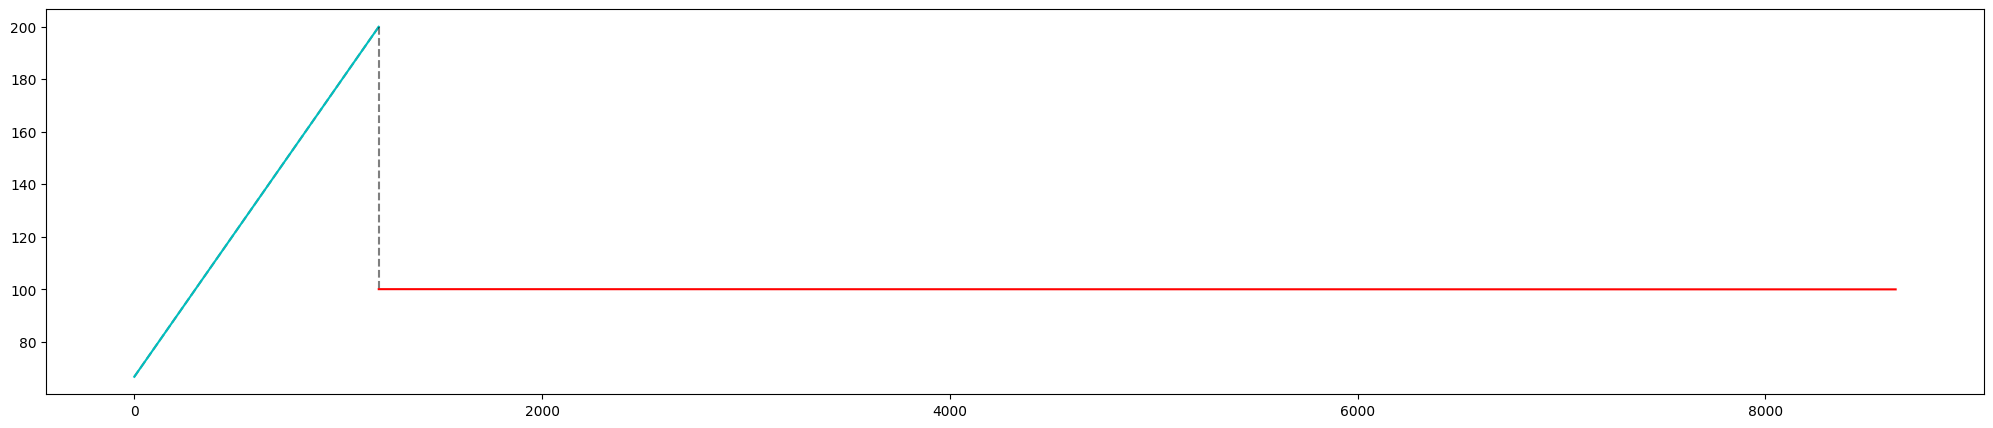

In [52]:
max_error = 1000000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

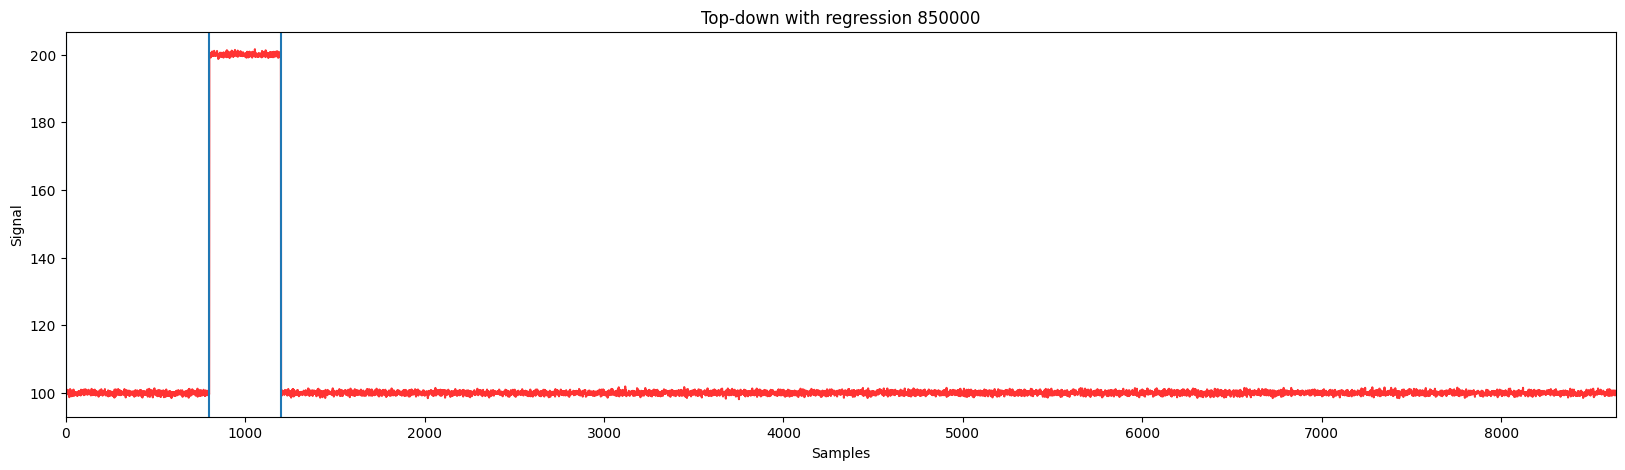

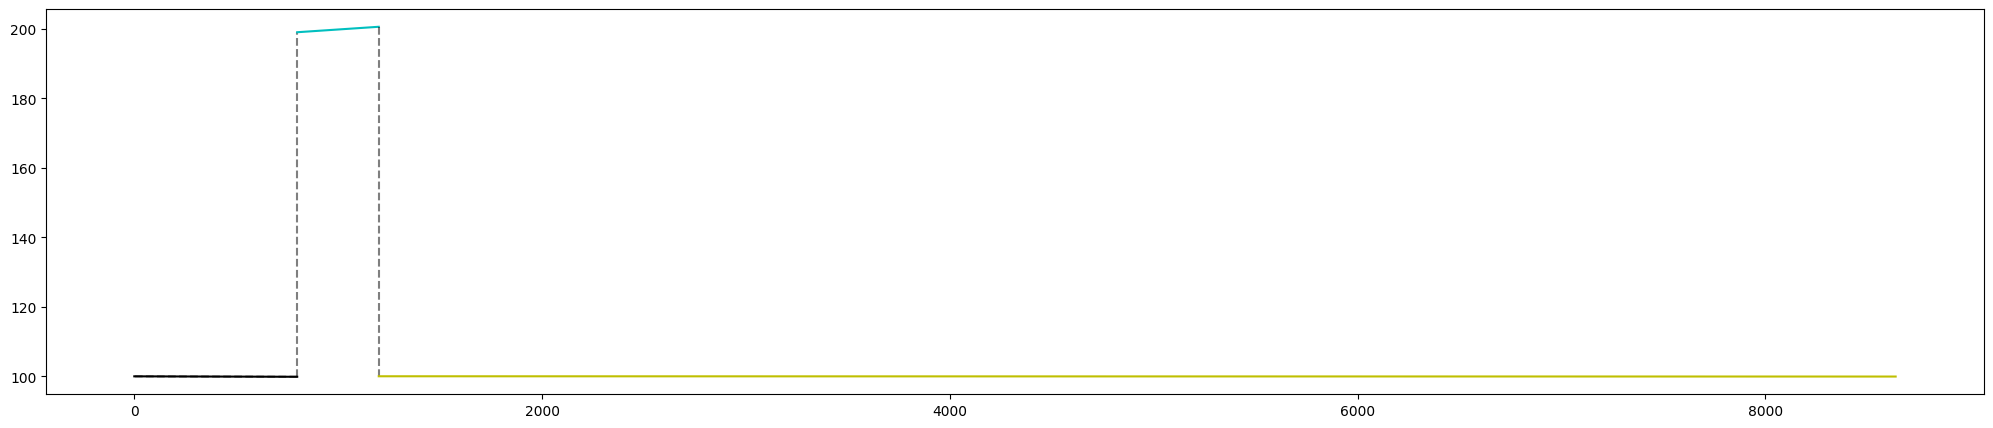

In [56]:
max_error = 850000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

## Best

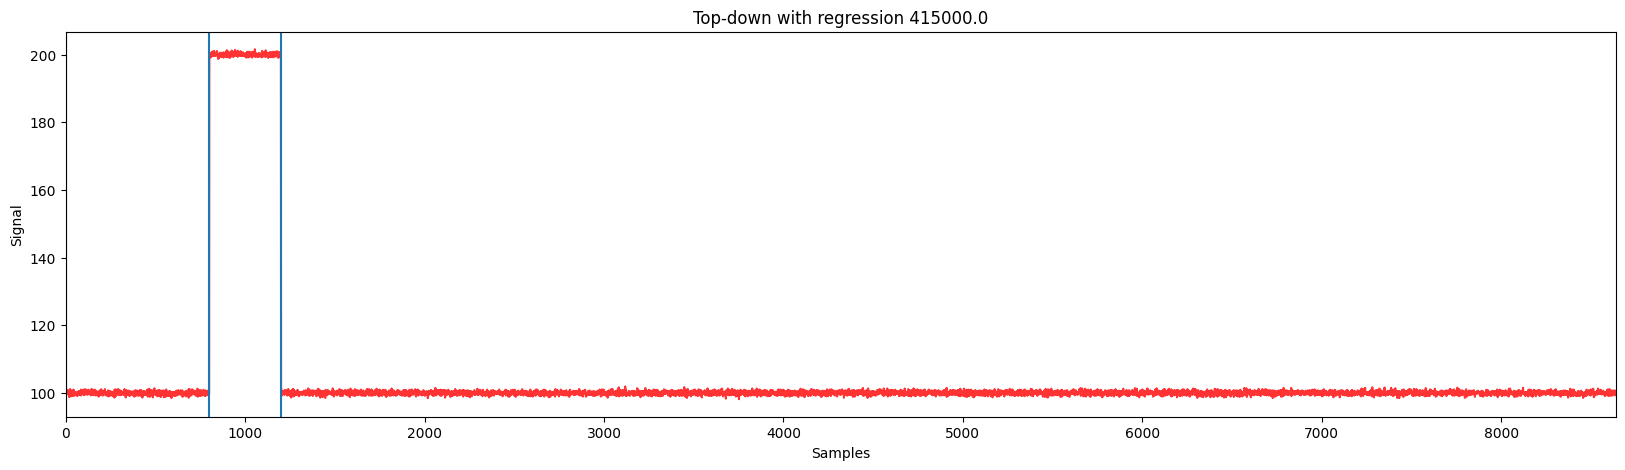

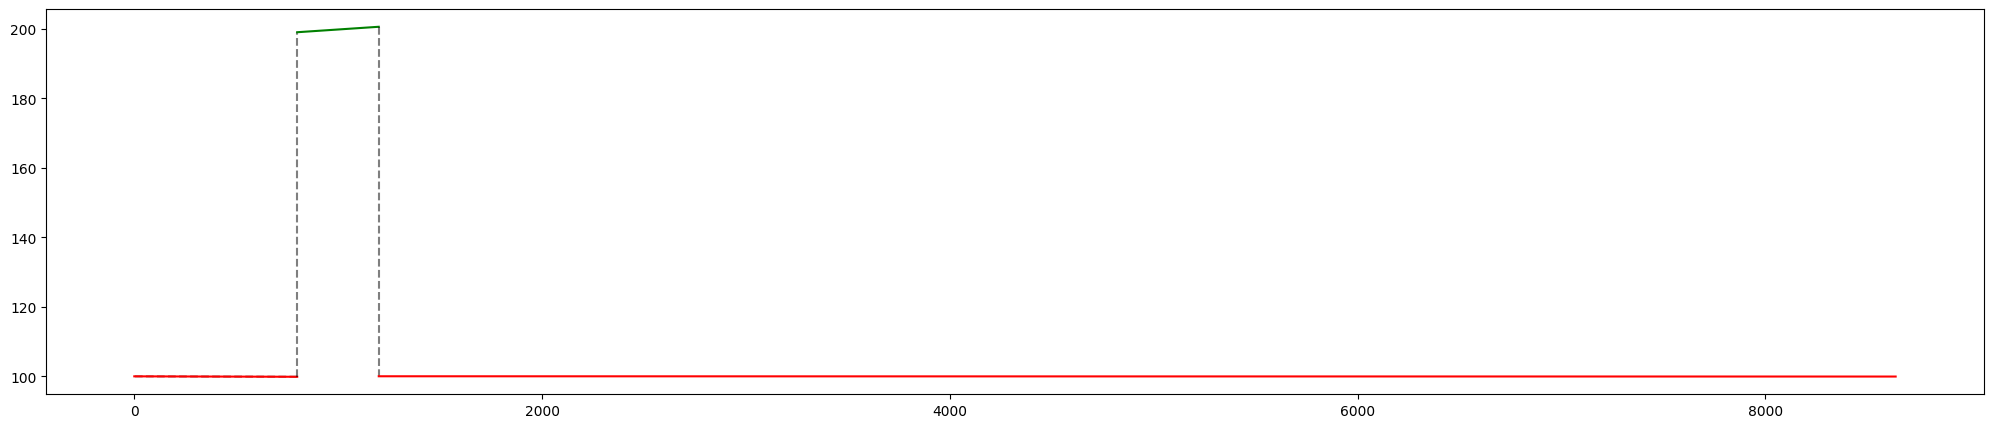

In [20]:
max_error = 415000.0
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

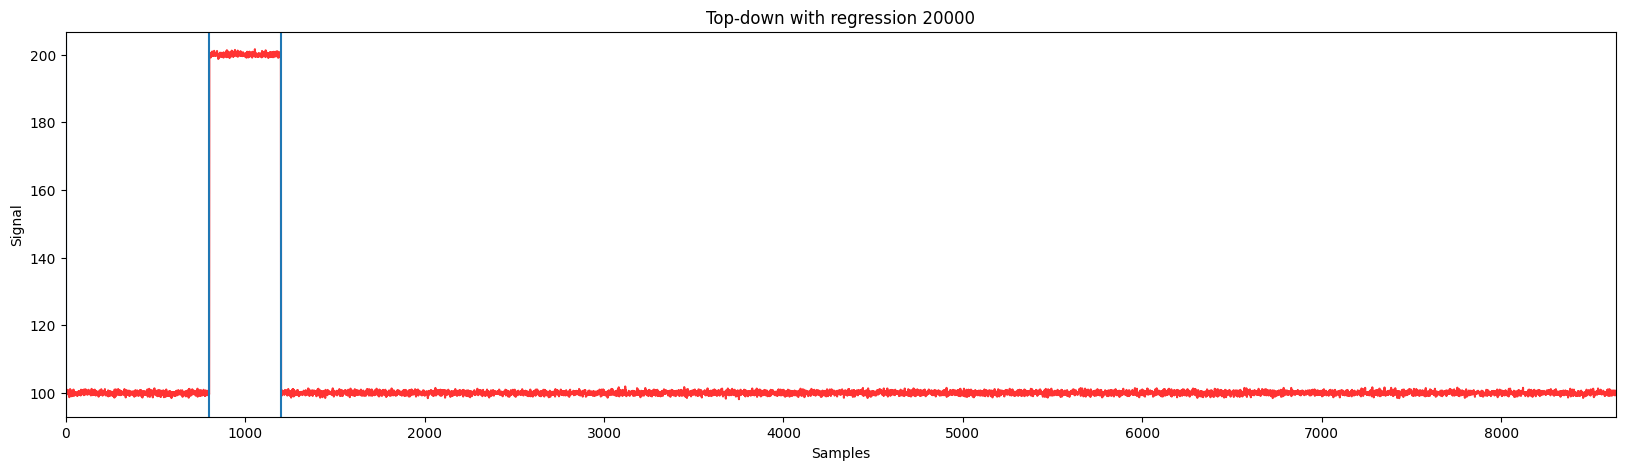

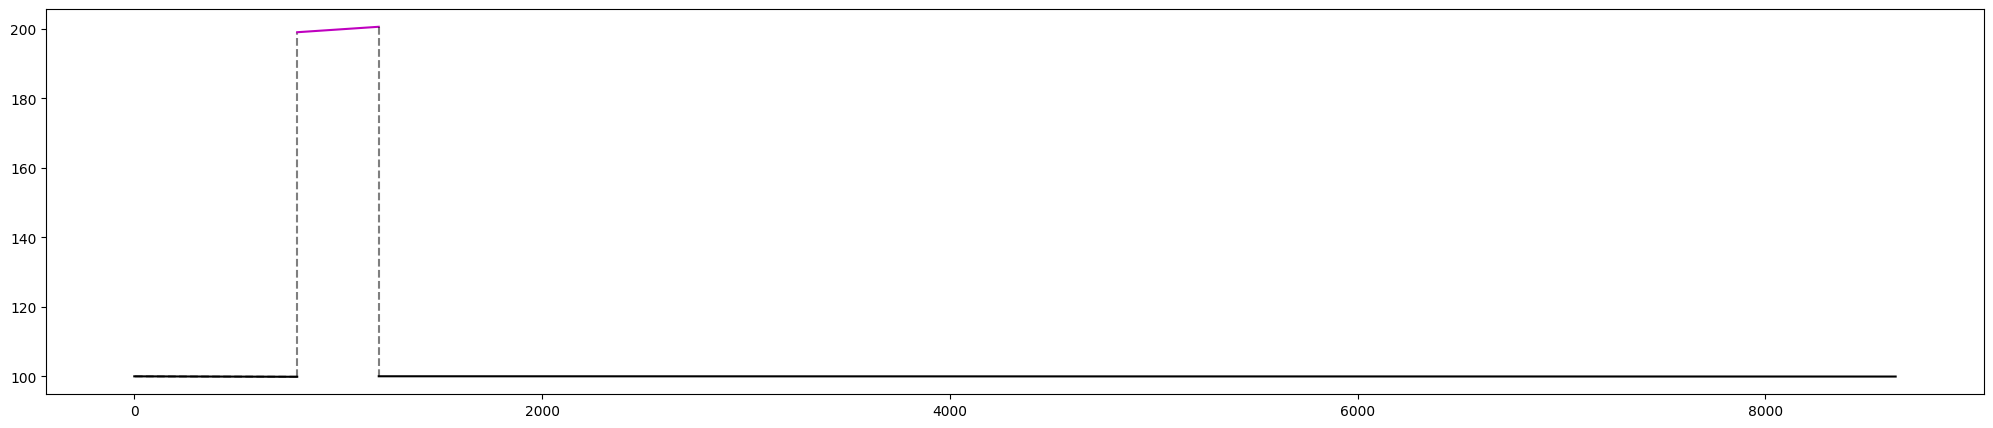

In [45]:
max_error = 20000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

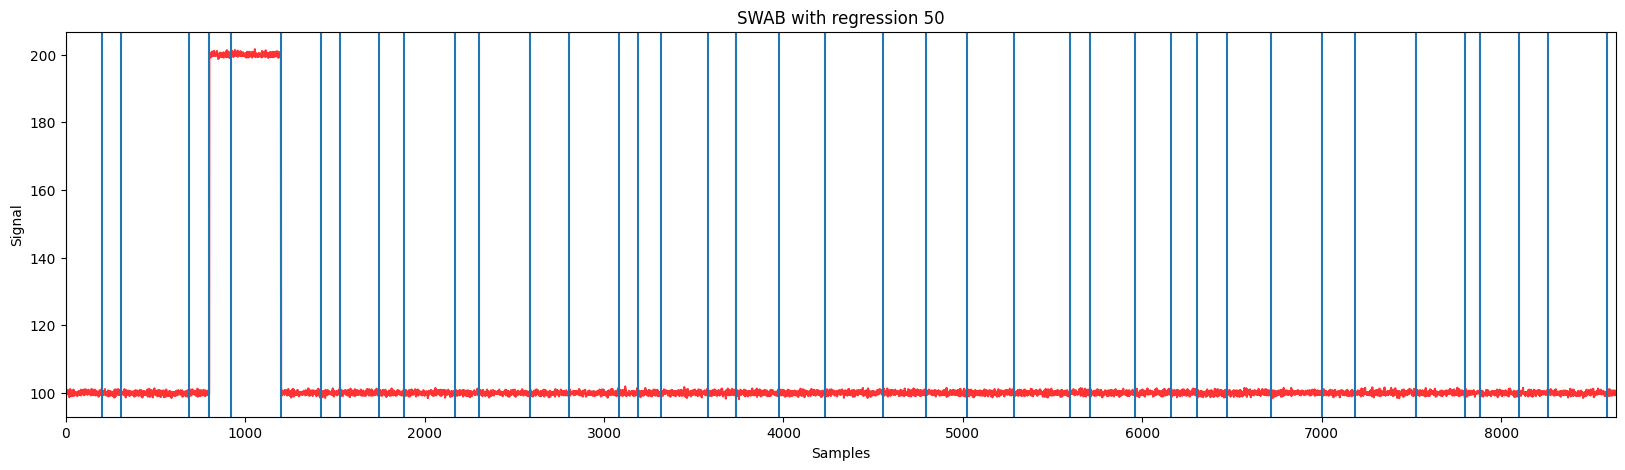

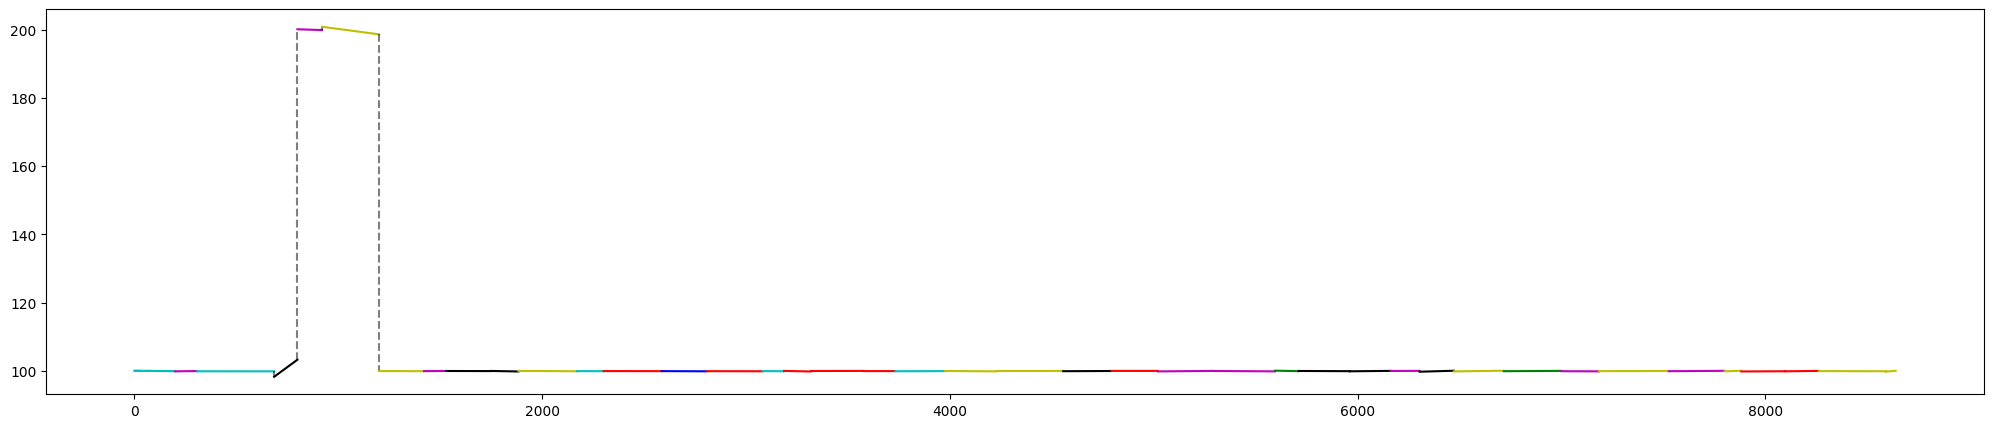

In [108]:
max_error = 50
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [21]:
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

,Metrics,Score
0,Accuracy,0.999769
1,Precision,0.997500
2,Recall,0.997500
3,F1-score,0.997500


In [19]:
range_max_error_topdown = (50,850000)
best_Top_down = 415000
time_avg_Top_down = 18.5

# Bottom-up

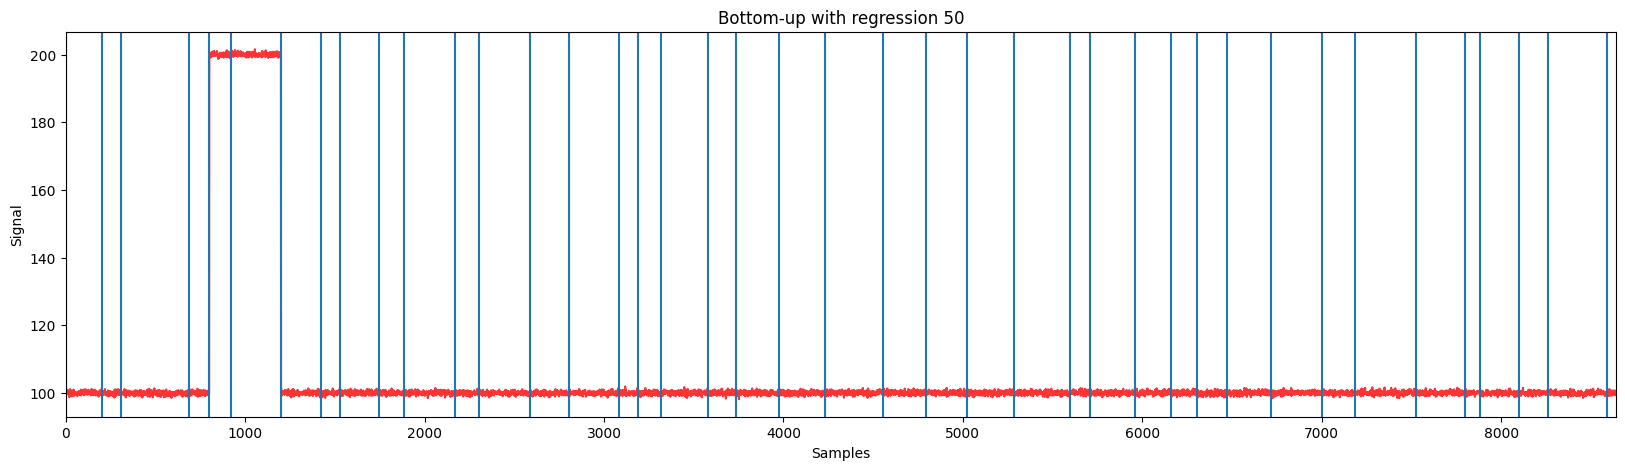

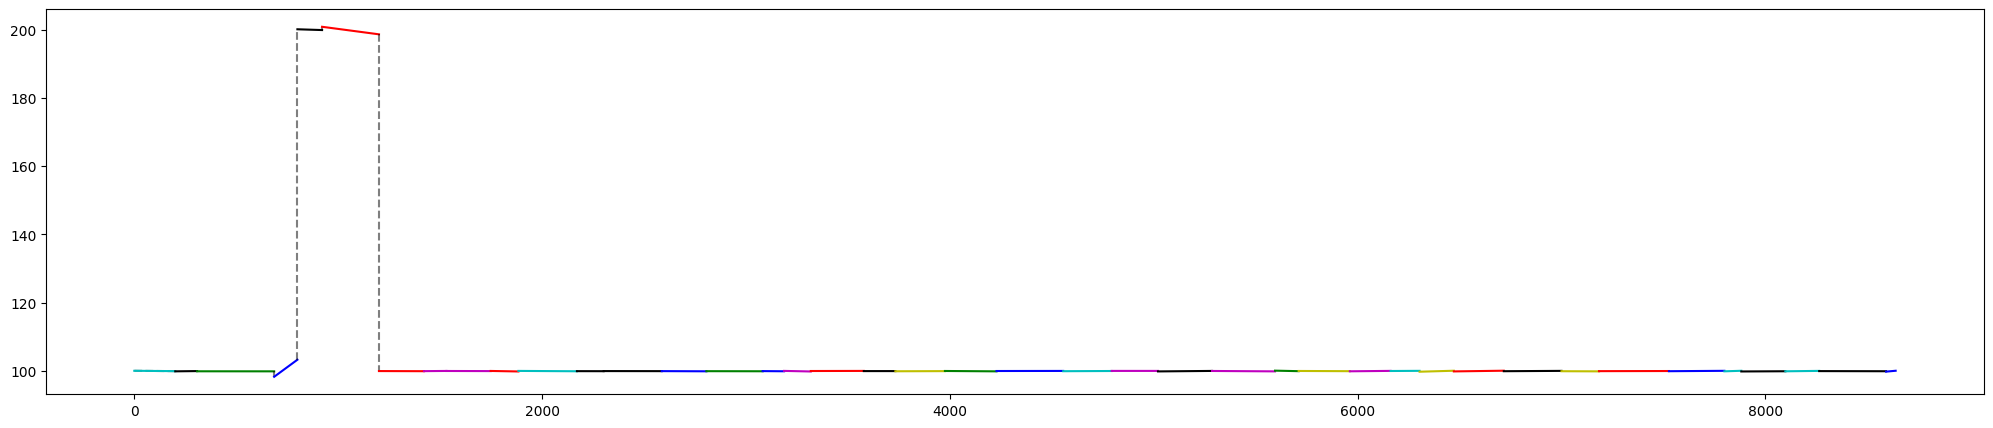

In [150]:
max_error = 50
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

## Best

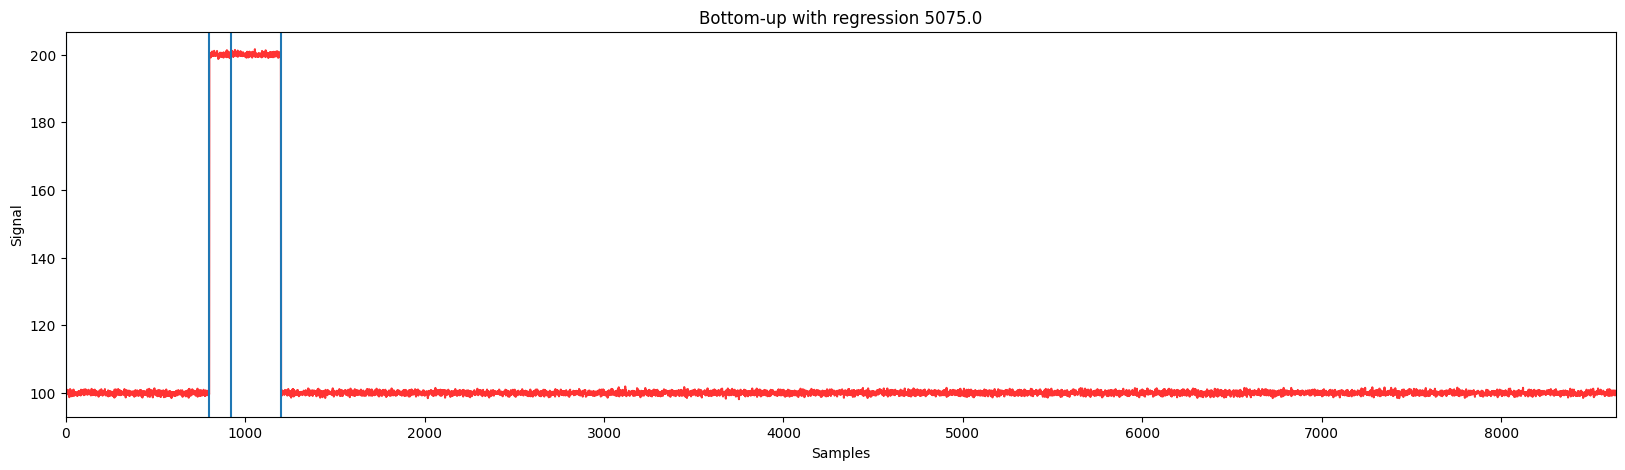

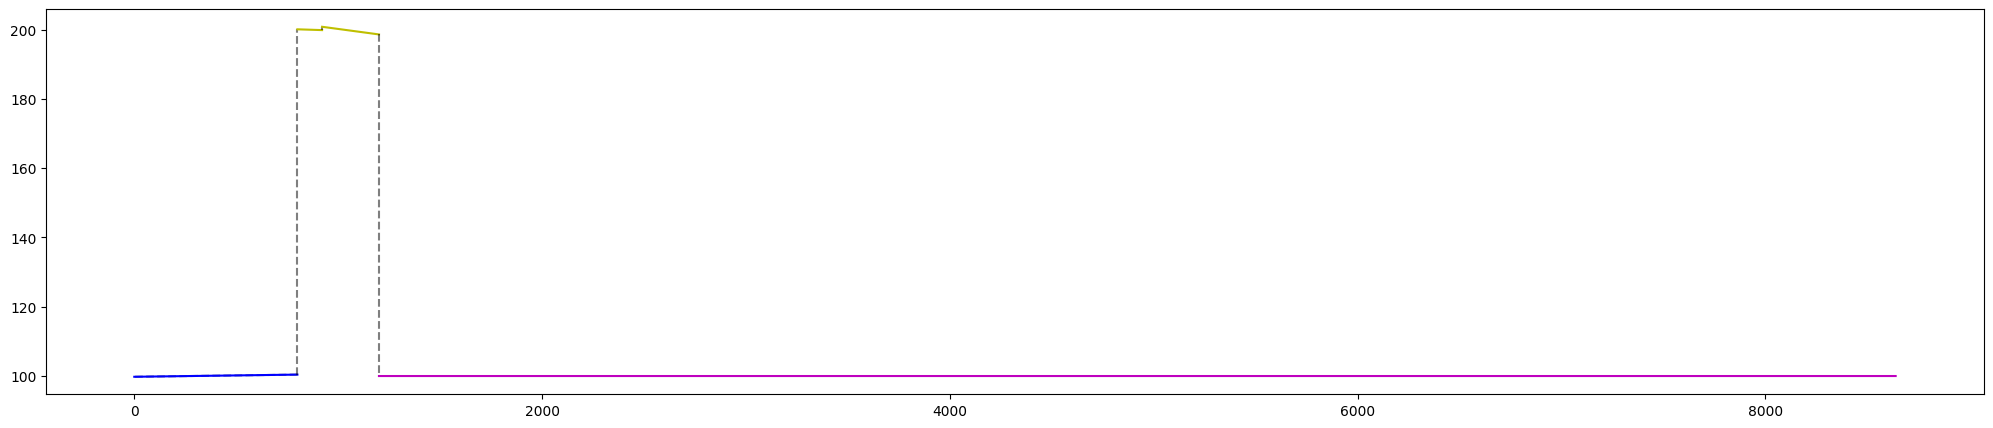

In [17]:
max_error = 5075.0
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [18]:
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

,Metrics,Score
0,Accuracy,0.985995
1,Precision,1.000000
2,Recall,0.697500
3,F1-score,0.821797


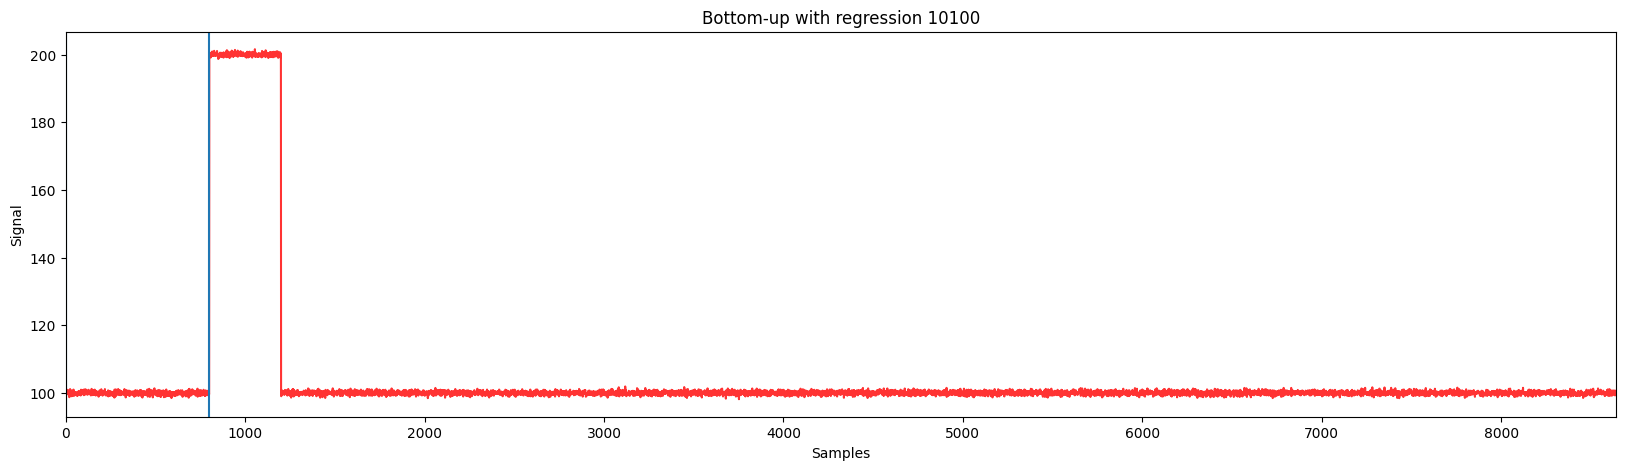

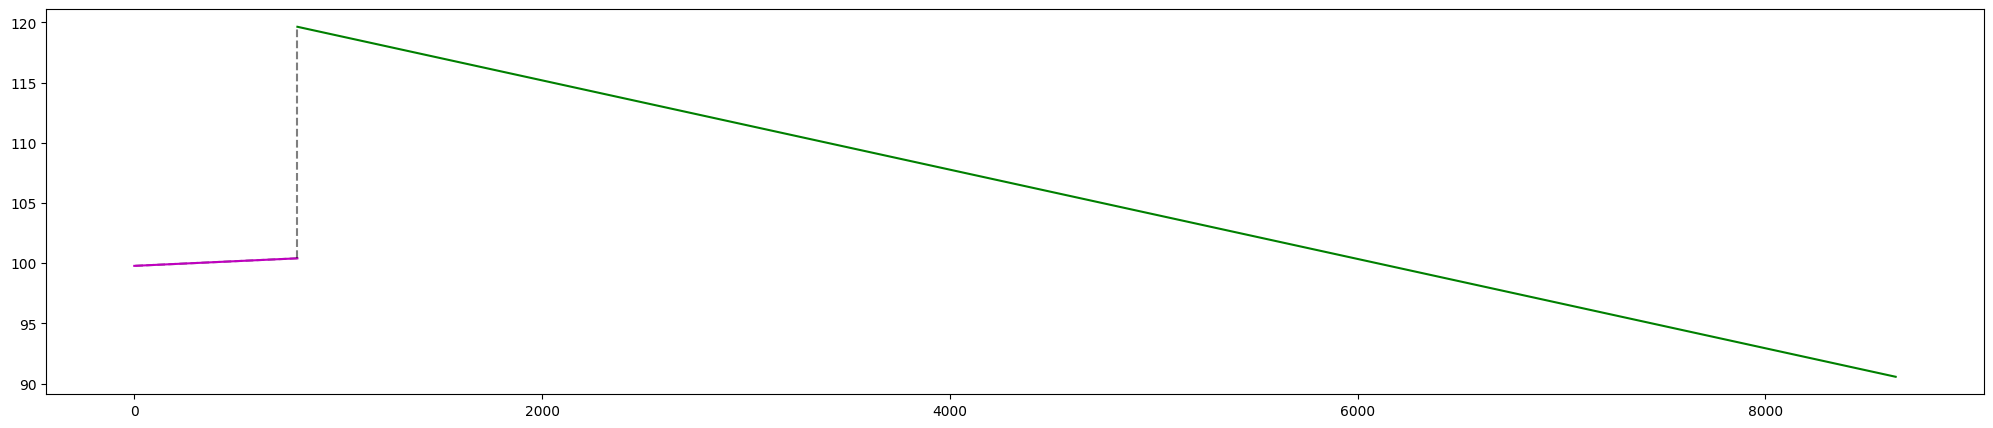

In [147]:
max_error = 10100
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [275]:
(5.35 +5.02)/2

5.185

In [16]:
range_max_error_bottomup = (50,10100)
best_Bottom_up = 5075
time_avg_Bottom_up = 5.185

# Sliding window

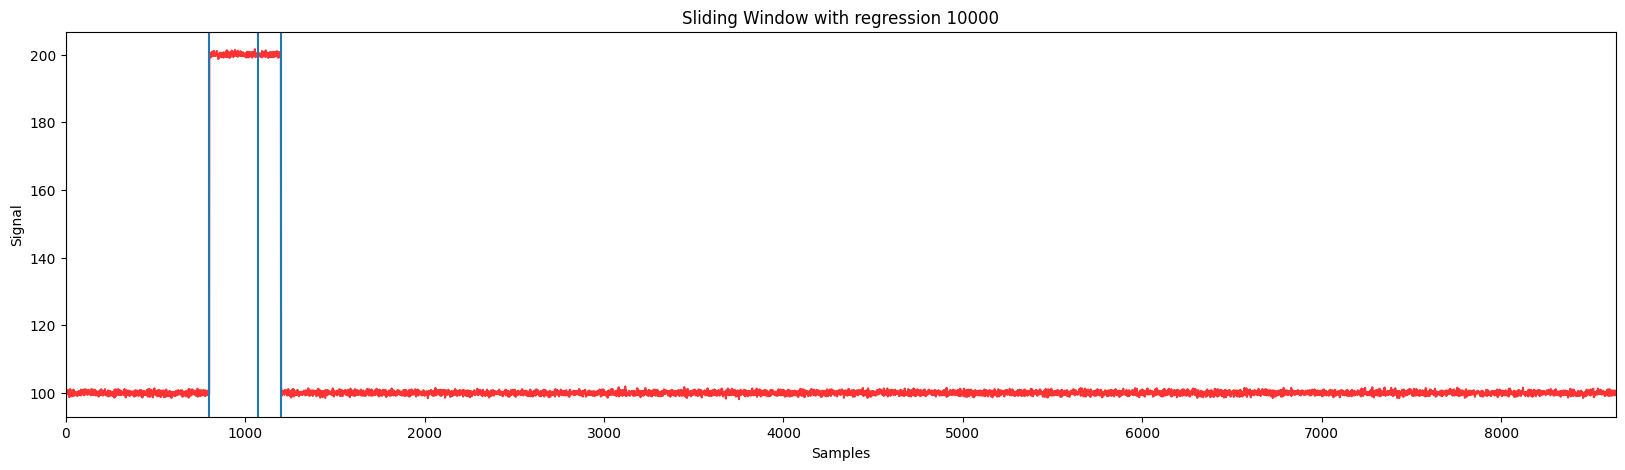

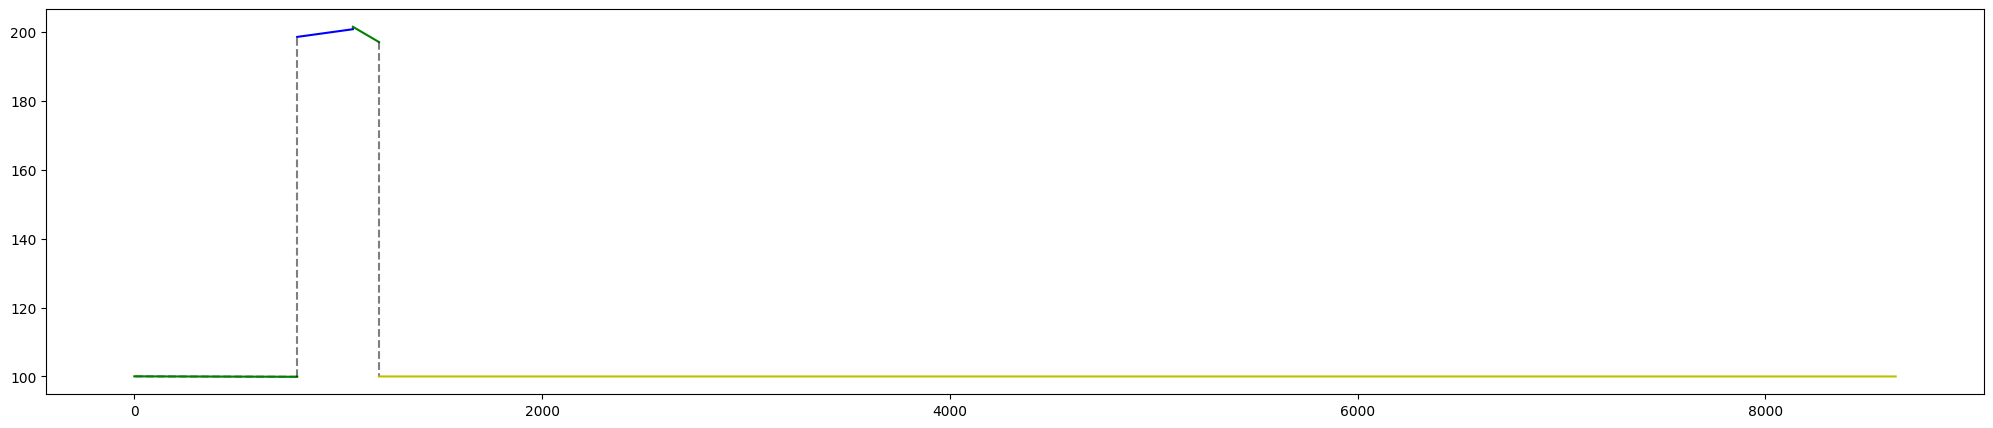

In [233]:
max_error = 10000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

## Best

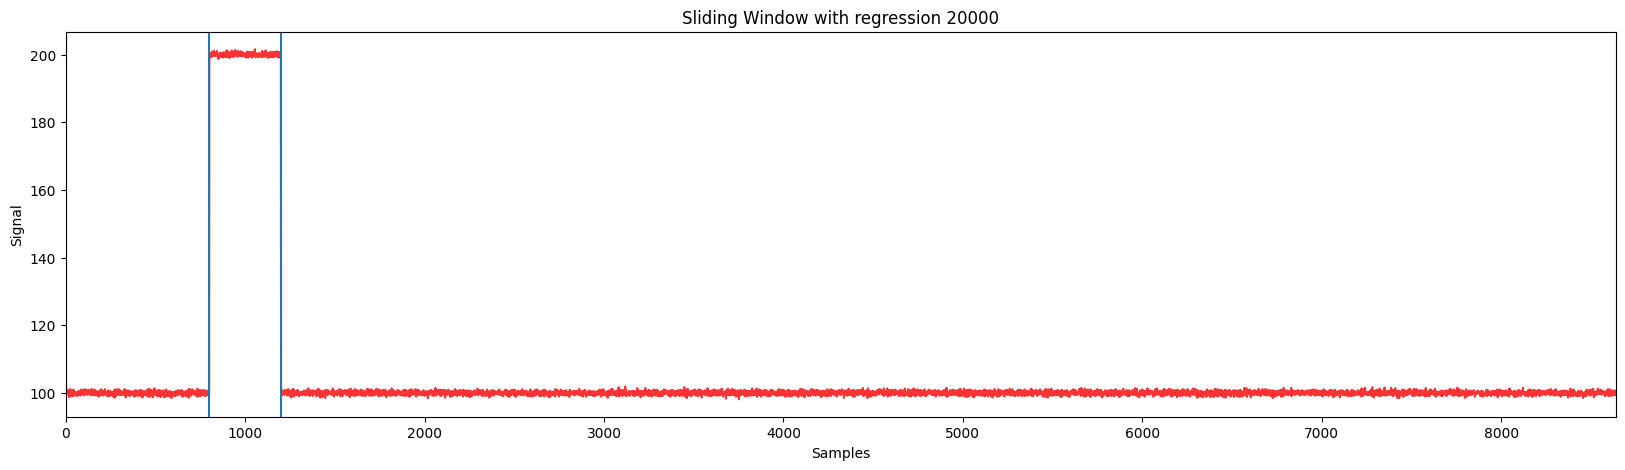

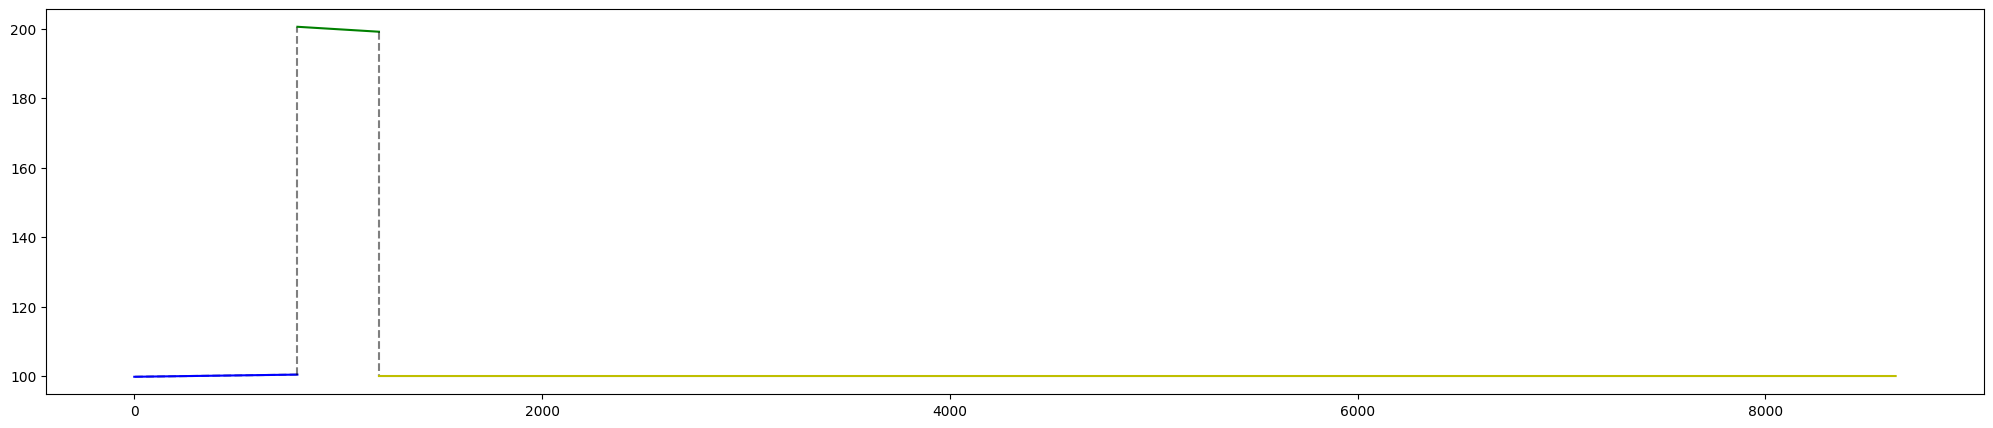

In [12]:
max_error = 20000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

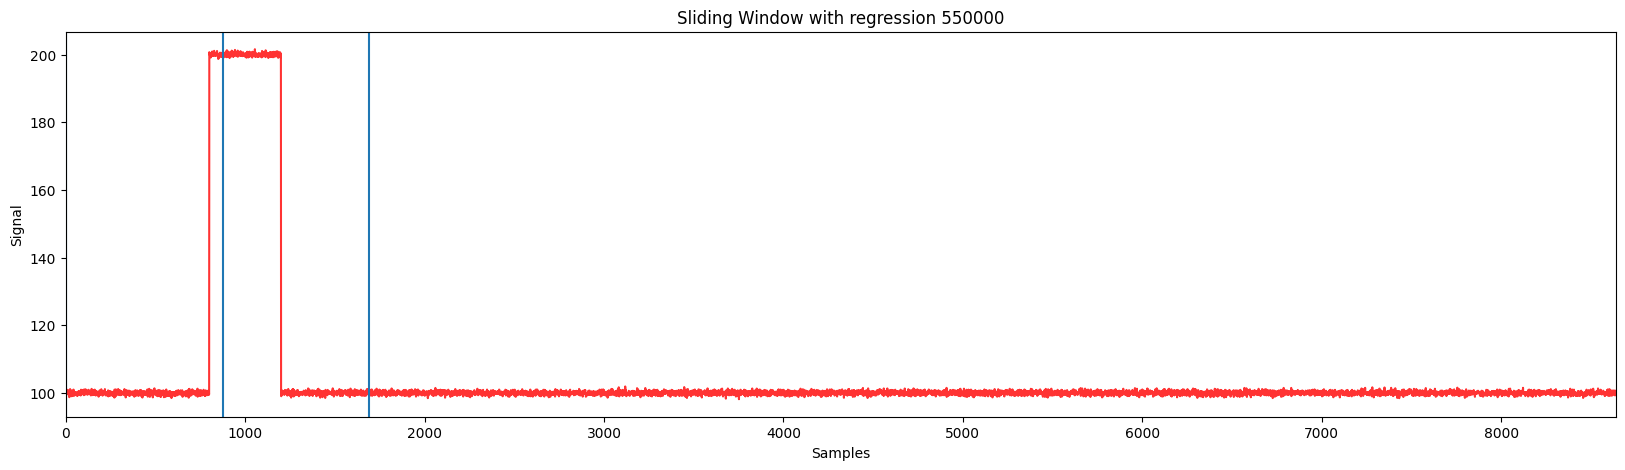

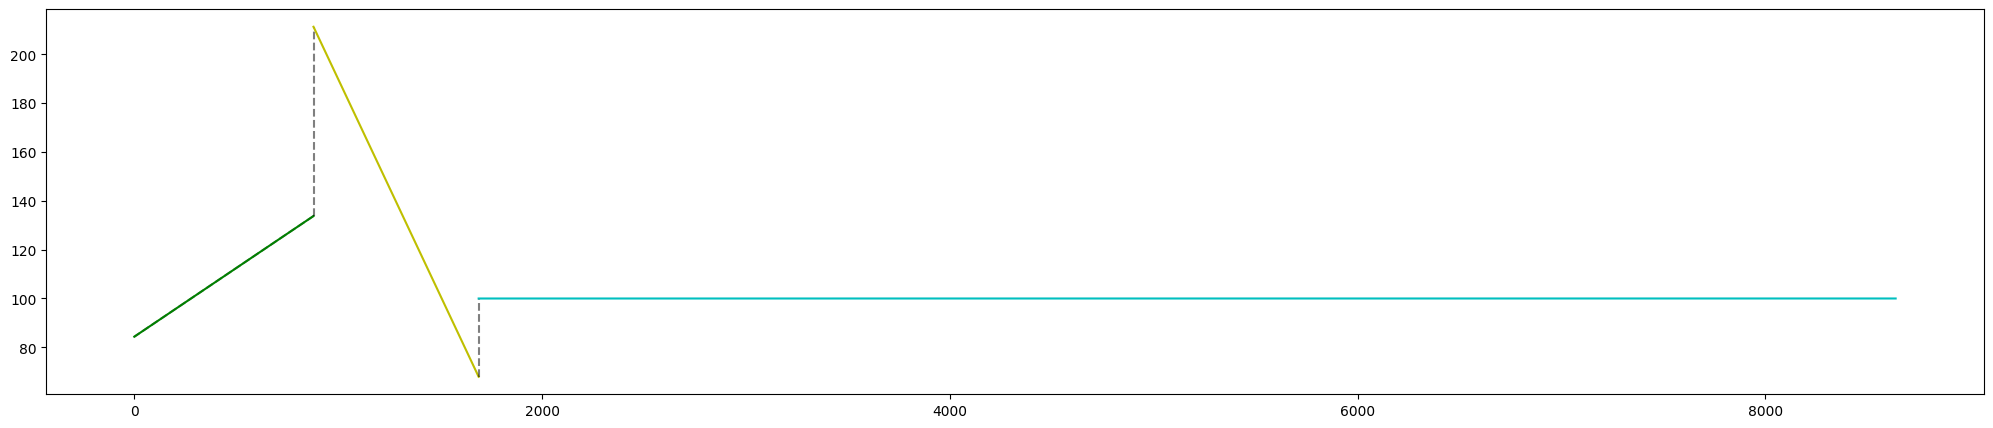

In [221]:
max_error = 550000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [13]:
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

,Metrics,Score
0,Accuracy,1.0
1,Precision,1.0
2,Recall,1.0
3,F1-score,1.0


In [277]:
(4.09+4.05)/2

4.07

In [14]:
range_max_error_sldw = (10000,550000)
best_sliding_window = 20000
time_avg_sliding_window = 4.07

# SWAB

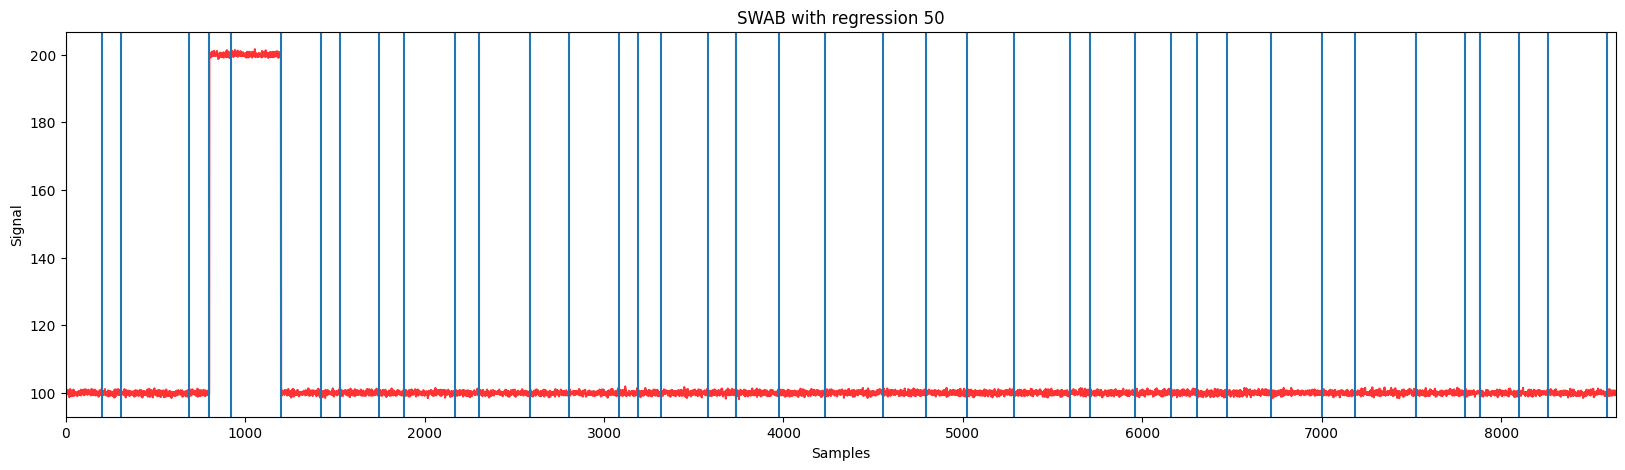

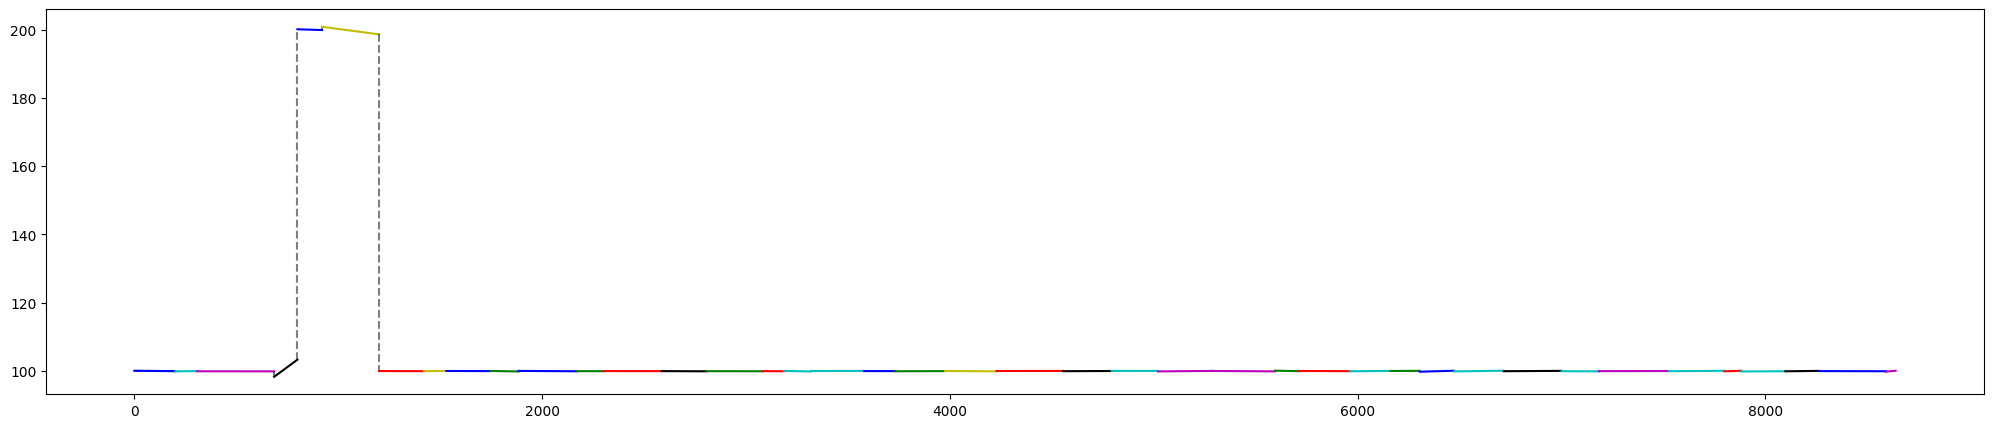

In [262]:
max_error = 50
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

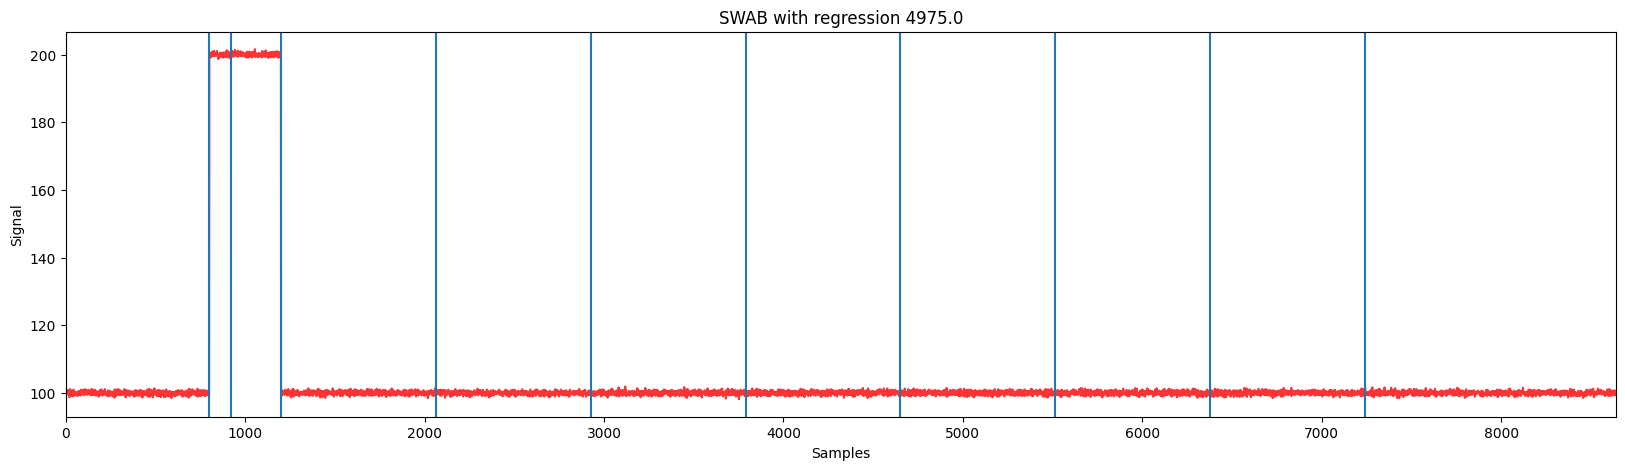

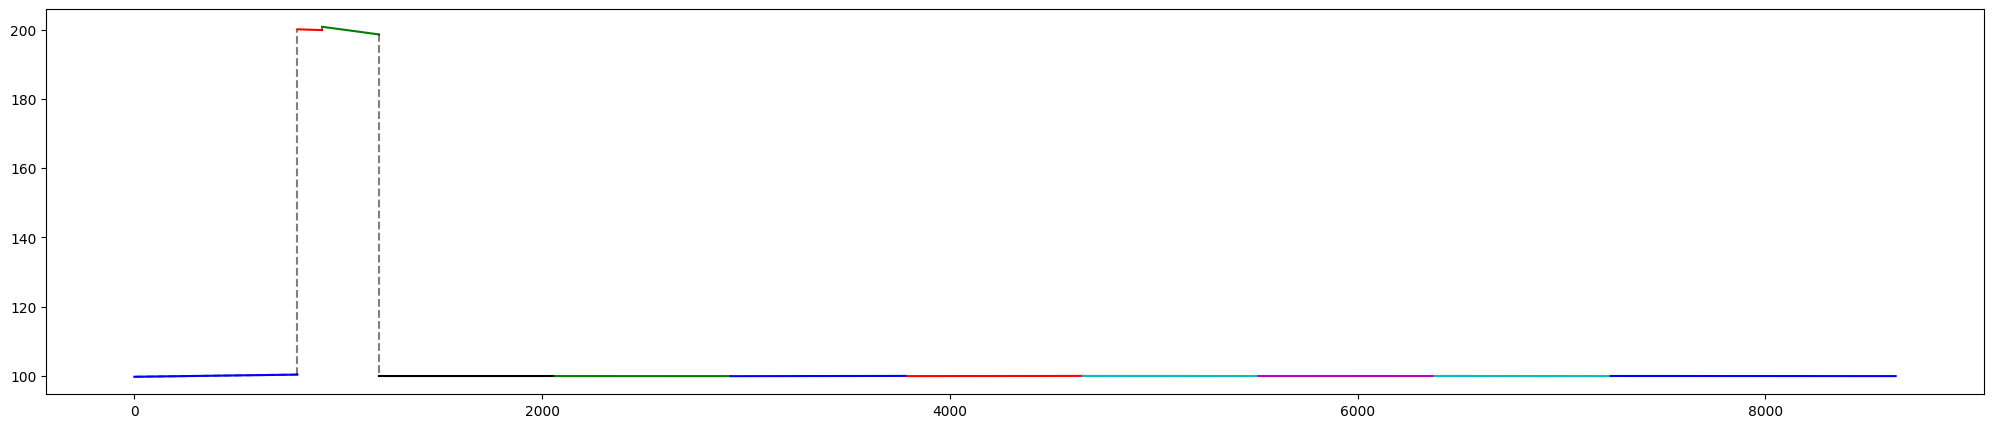

In [9]:
max_error = 4975.0
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

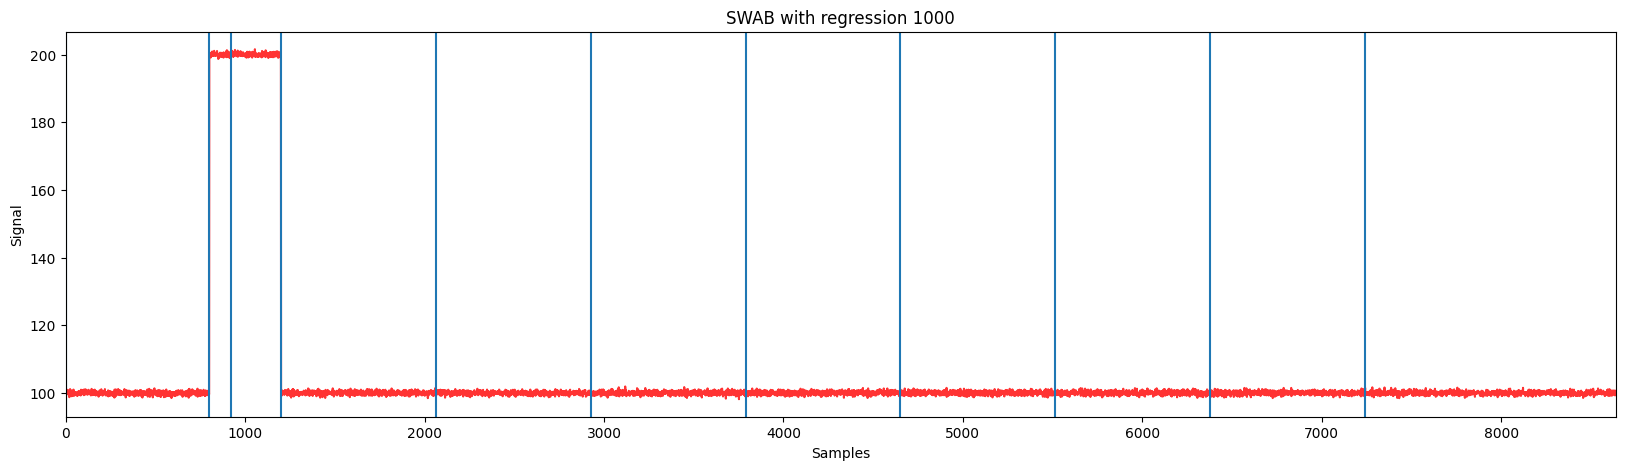

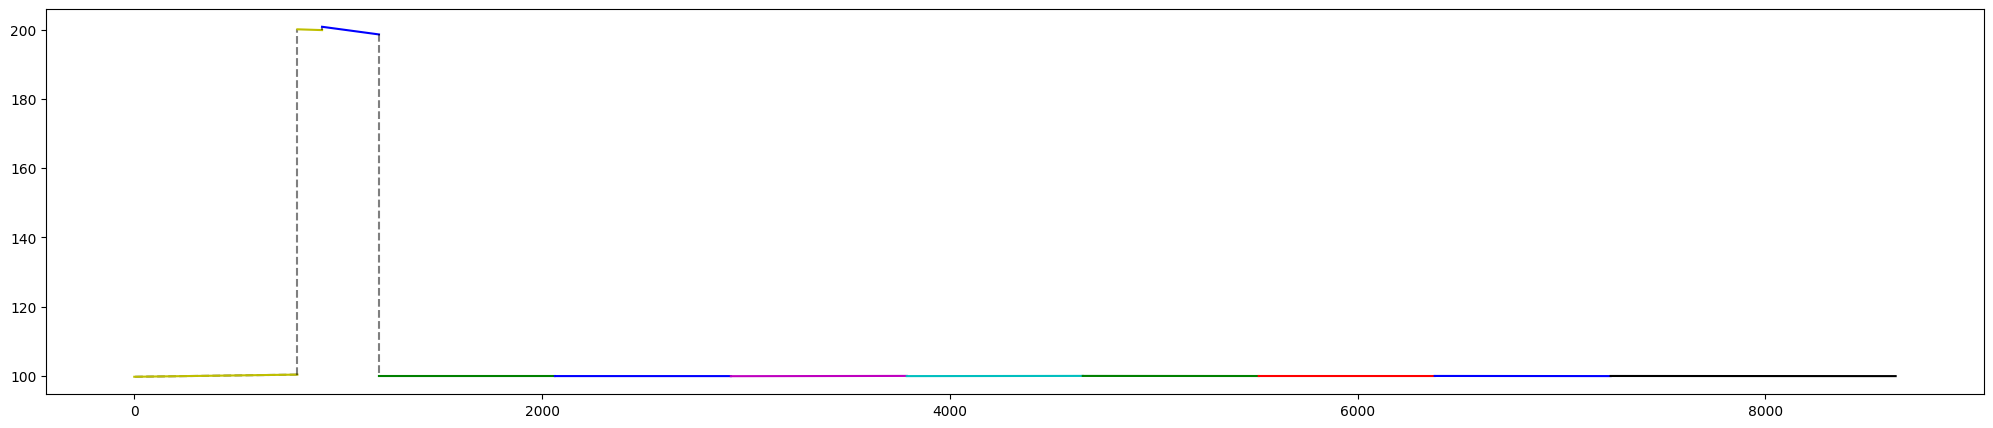

In [244]:
max_error = 1000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [253]:
#10000

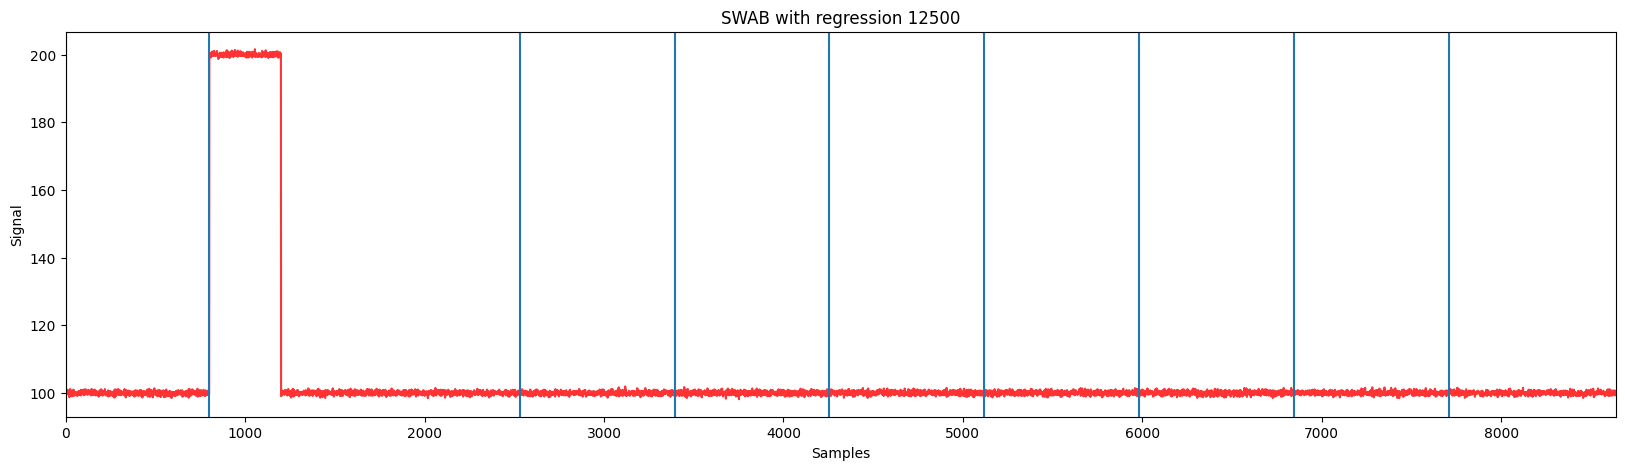

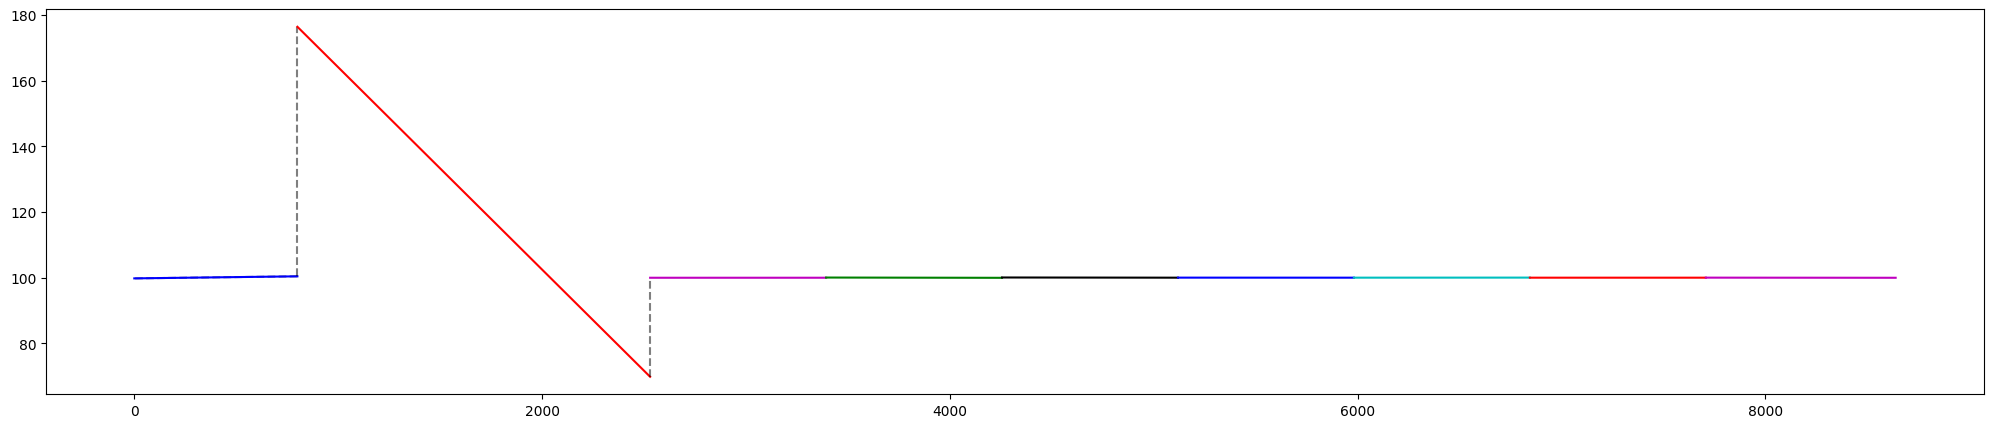

In [252]:
max_error = 12500
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [10]:
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

,Metrics,Score
0,Accuracy,0.985995
1,Precision,1.000000
2,Recall,0.697500
3,F1-score,0.821797


In [279]:
(7.84+27.1)/2

17.47

In [15]:
range_max_error_swab = (50,12500)
best_swab = 4975
time_avg_swab = 17.47

# Conclusion

In [63]:
data = {
    'Id' : [1,1,1,1],
    'Algorithm': ['Top-down', 'Bottom-up', 'Sliding-window','SWAB'],
    'min(max_error)': [range_max_error_topdown[0],range_max_error_bottomup[0], range_max_error_sldw[0],range_max_error_swab[0]],
    'max(max_error)': [range_max_error_topdown[1],range_max_error_bottomup[1],range_max_error_sldw[1],range_max_error_swab[1]],
    'Best': [best_Top_down, best_Bottom_up,best_sliding_window,best_swab],
    'Time Average(in range)': [time_avg_Top_down, time_avg_Bottom_up, time_avg_sliding_window,time_avg_swab],
    'Accuracy' : [acc_topdown,acc_btu,acc_sldw,acc_swab],
    'Precision' : [pre_topdown,pre_btu,pre_sldw,pre_swab],
    'Recall' : [recall_topdown,recall_btu,recall_sldw,recall_swab],
    'F1-score' : [f1_topdown,f1_btu,f1_sldw,f1_swab],
    'Rank' : [2,3,1,3]
}

conclusion_df = pd.DataFrame(data)
conclusion_df

,Id,Algorithm,min(max_error),max(max_error),Best,Time Average(in range),Accuracy,Precision,Recall,F1-score,Rank
0,1,Top-down,50,850000,415000,18.500,0.999769,0.9975,0.9975,0.997500,2
1,1,Bottom-up,50,10100,5075,5.185,0.985995,1.0000,0.6975,0.821797,3
2,1,Sliding-window,10000,550000,20000,4.070,1.000000,1.0000,1.0000,1.000000,1
3,1,SWAB,50,12500,4975,17.470,0.985995,1.0000,0.6975,0.821797,3


# To exp

In [64]:
old_conclusion_df = pd.read_csv('exp\Conclusion.csv')
add_df = conclusion_df.drop(columns='Rank')
conclusion_df = pd.concat([old_conclusion_df, add_df], ignore_index=True)
conclusion_df = conclusion_df.drop_duplicates()
conclusion_df.to_csv('exp\Conclusion.csv',index=False)

In [76]:
feature_max_error = pd.DataFrame(data=extracted_relevant_feature.T)
feature_max_error['id'] = 1
feature_max_error['Num_points'] = num_datapoints
feature_max_error['Min(max_error)_Top_down'] = range_max_error_topdown[0]
feature_max_error['Max(max_error)_Top_down'] = range_max_error_topdown[1]
feature_max_error['Min(max_error)_Bottom_up'] = range_max_error_bottomup[0]
feature_max_error['Max(max_error)_Bottom_up'] = range_max_error_bottomup[1]
feature_max_error['Min(max_error)_SLDW'] = range_max_error_sldw[0]
feature_max_error['Max(max_error)_SLDW'] = range_max_error_sldw[1]
feature_max_error['Min(max_error)_SWAB'] = range_max_error_swab[0]
feature_max_error['Max(max_error)_SWAB'] = range_max_error_swab[1]
feature_max_error['Best(max_error)_SWAB'] = best_Top_down
feature_max_error['Best(max_error)_SWAB'] = best_Bottom_up
feature_max_error['Best(max_error)_SWAB'] = best_sliding_window
feature_max_error['Best(max_error)_SWAB'] = best_swab

numpoints_column = feature_max_error.pop('Num_points')
feature_max_error.insert(0, 'Num_points', numpoints_column)
id_column = feature_max_error.pop('id')
feature_max_error.insert(0, 'id', id_column)

In [77]:
old_feat_df = pd.read_csv('exp\Feature__Maxerror.csv')
add_feat_df = feature_max_error
feat_df = pd.concat([old_feat_df, add_feat_df], ignore_index=True)
feat_df = feat_df.drop_duplicates()
feat_df.to_csv('exp\Feature__Maxerror.csv',index=False)

In [78]:
feat_df

,id,Num_points,mean,median,variance,standard_deviation,absolute_sum_of_changes,mean_abs_change,kurtosis,minimum,maximum,Min(max_error)_Top_down,Max(max_error)_Top_down,Min(max_error)_Bottom_up,Max(max_error)_Bottom_up,Min(max_error)_SLDW,Max(max_error)_SLDW,Min(max_error)_SWAB,Max(max_error)_SWAB,Best(max_error)_SWAB
0,2,8640,102.151881,100.286884,212.017664,14.560826,95822.993645,11.091908,4.776042,62.598994,181.709748,50000,350000,30000,90000,35000,150000,30000,90000,60000
1,1,8640,104.621483,100.014344,442.227086,21.029196,4986.149682,0.577167,16.640276,98.129950,201.585487,50,850000,50,10100,10000,550000,50,12500,4975
